# Read and process groundwater data ILVO Field

Load essential Python modules

In [2]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)

#!pip install traces

### Read Climate Data  (www.dacom.nl)

In [28]:
path1 = os.getcwd()
path = os.path.join(path1, 'data', 'raw_data')
file = os.path.join(path, 'weather_data.csv')

#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';', parse_dates=[['date','time']],dayfirst=True)
#clim['date_time']=pd.to_datetime(clim['date_time'], unit='s')
clim2=clim.set_index('date_time')
climdaily=clim2.resample('D').agg({'precipitation': np.sum})#, 'air_temperature': np.mean,'rel_humidity': np.mean})
#climdaily.reset_index().plot(kind='scatter', x='date_time', y='precipitation')

print(climdaily)
climdaily.to_excel('saved_climfile2.xlsx')


            precipitation
date_time                
2022-01-08            0.0
2022-01-09            0.0
2022-01-10            6.8
2022-01-11            0.0
2022-01-12            0.0
...                   ...
2022-12-05            0.0
2022-12-06            0.0
2022-12-07            0.0
2022-12-08            0.0
2022-12-09            0.0

[336 rows x 1 columns]


### Read data

In [23]:
datapath =  os.path.join(path1, 'data')
baro_ind='AP825'
xls_files = glob.glob(datapath + "\*.xlsx") # change to csv 
#barometer felt down in pipe on   '2022-05-25 07:25:00'  
#loop over the list of xls files
ind = 0
diver_names={}
alldf={}
for i,f in tqdm(enumerate(xls_files),total=len(xls_files)):
    # read the csv file
    df = pd.read_excel(f)
    #print(df)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    df=df.assign(Date=df.TimeStamp.dt.round('H'))
    
    df['Date']=pd.to_datetime(df['Date'],dayfirst=True)
    df=df.loc[(df['TimeStamp'] > '2022-08-02 12:00:00')]
    dfdaily=df.resample('D', on = 'Date').mean()

    # merge all data in 1 dataframe
    if baro_ind in f:
        baro_data=df
        baro_data=baro_data.loc[(baro_data['TimeStamp'] > '2022-08-02 12:00:00')]
        #baro_data=baro_data.append.df# this tests for substrings
    if ind == 0:
        #First data frame loaded
        GWdata = df
        GWdata_daily = dfdaily
    else:
        # Paste the rest to this dataframe
        GWdata = pd.concat([GWdata,df],axis=0).reset_index(drop=True)
        GWdata_daily = pd.concat([GWdata_daily,df],axis=0).reset_index(drop=True)
        alldf[i]=df
        alldf[i]=alldf[i].loc[(alldf[i]['TimeStamp'] > '2022-08-02 12:00:00')]
        GWdata
    ind = ind + 1 
#Remove empty columns from the dataframe    
#GWdata.drop(labels=['Conductivity', 'WaterLevel','WaterLevelReference'], axis=1)
#GWdata.loc[GWdata["SerialNumber"]=='AP825'].reset_index()
#baro_data.reset_index()

print(GWdata)
print(baro_data)
GWdata.to_excel('saved_file1.xlsx')


C:\Users\brasp\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




      MonitoringPoint SerialNumber           TimeStamp     Pressure  \
0                ILVO        AP689 2022-08-02 12:30:00  1099.600000   
1                ILVO        AP689 2022-08-02 13:00:00  1099.325000   
2                ILVO        AP689 2022-08-02 13:30:00  1098.866667   
3                ILVO        AP689 2022-08-02 14:00:00  1098.775000   
4                ILVO        AP689 2022-08-02 14:30:00  1098.591667   
...               ...          ...                 ...          ...   
29545            ILVO        AZ649 2022-11-04 12:00:00  1137.333333   
29546            ILVO        AZ649 2022-11-04 13:00:00  1138.091667   
29547            ILVO        AZ649 2022-11-04 14:00:00  1138.558333   
29548            ILVO        AZ649 2022-11-04 15:00:00  1027.900000   
29549            ILVO        AZ649 2022-11-04 16:00:00  1148.650000   

       Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0        15.203333           NaN         NaN                  NaN   
1       

In [5]:
# Read manually measured water dephts for inspection of the data    
path_obs=os.path.join(path1, 'data','raw_data')
file_obs = os.path.join(path_obs, 'manual_check_water_depth.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Time']=pd.to_datetime(df_info['Time'],dayfirst=True)
(df_info.Time)
df_info2=df_info[df_info.Time.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2.iloc[:,3] = (-100*df_info2.iloc[:,3]) 
df_info2.iloc[:,4] =-100*df_info2.iloc[:,4] 
groups = df_info2.groupby('SerialNumber')
colors = {'AG083':'#ff7f0e','AP707': '#8c564b','CA186': '#d62728','AZ649': '#2ca02c', 'CA969':'#9467bd'}
print(df_info2)

   piezometer SerialNumber                Time  Measured Depth  \
0           a        AG083 2022-08-02 17:00:00          -215.0   
1           a        AG083 2022-08-18 09:36:00          -216.0   
2           a        AG083 2022-09-09 10:25:00          -224.0   
3           a        AG083 2022-09-14 15:17:00          -221.0   
4           a        AG083 2022-09-20 10:04:00          -215.0   
5           a        AG083 2022-10-17 15:30:00          -202.0   
6           b        AP707 2022-08-02 17:50:00          -210.0   
7           b        AP707 2022-08-18 09:40:00          -205.0   
8           b        AP707 2022-09-09 10:30:00          -210.0   
9           b        AP707 2022-09-14 15:00:00          -208.0   
10          b        AP707 2022-09-20 10:15:00          -200.0   
11          b        AP707 2022-10-17 15:30:00          -189.0   
12          c        CA186 2022-08-02 12:15:00          -215.0   
13          c        CA186 2022-08-18 09:42:00          -194.0   
14        

## Processing steps

Dataset Processing explanation						
1. Collect total pressure (TP) from divers		 (cmH2O)				
2. Calculate water pressure (WP) = TP - AP		 (cmH2O)		
3. Calculate hydraulic gradient. Take the timestep "t" at which a manual measurement is realized and calculate the hydraulic head						
     - H(t) = TW-WD(t)						
     - H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
																	
With :											
AP= Air Pressure (cmH20)											
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)												
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) | rope length (m)|
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|:------------|
|  AG083  |   a   |         21,30        |                 0.56                |      21,86      |    |
|   AP707   |   b   |        20,5        |               0.43               |      20.93      |      |
|   CA186  |   c   |       19,7         |               0.63               |        20.33    |        |
|   AZ649   |   d   |         20,9        |              0.68                |      21.58      |      |
|   CA969  |  e  |         22,3        |                0.7               |      23.0     |       |
|   AP689   |     |                 |                            |            |           |

      index MonitoringPoint SerialNumber           TimeStamp  Pressure_x  \
0         0            ILVO        CA969 2022-08-02 13:00:00    1037.700   
1         1            ILVO        CA969 2022-08-02 13:00:00    1037.700   
2         2            ILVO        CA969 2022-08-02 14:00:00    1037.650   
3         3            ILVO        CA969 2022-08-02 14:00:00    1037.650   
4         4            ILVO        CA969 2022-08-02 15:00:00    1036.825   
...     ...             ...          ...                 ...         ...   
1641   2077            ILVO        CA969 2022-09-20 05:00:00    1044.025   
1642   2078            ILVO        CA969 2022-09-20 06:00:00    1043.900   
1643   2079            ILVO        CA969 2022-09-20 07:00:00    1044.275   
1644   2080            ILVO        CA969 2022-09-20 08:00:00    1045.050   
1645   2081            ILVO        CA969 2022-09-20 09:00:00    1044.675   

      Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       31.850000  

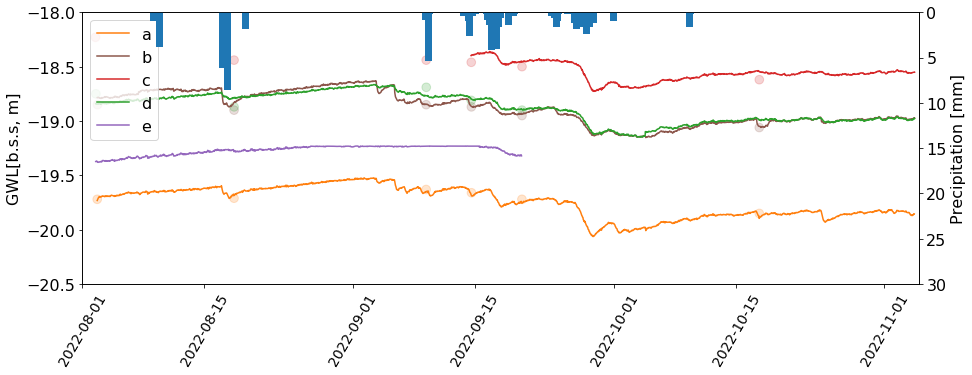

In [16]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969'], 
            'WellName' : {'a','b','c','d','e'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.30,20.5,19.7,20.9,22.3],
            'well_height' : [0.56,0.43,0.63,0.68,0.70],
            'top_well_cm' :[2186,2093,2033,2158,2300],
            'RL' : [350,332,341,370,377],
            'L1':[294,289,278,302,307],
            'initials' : [158,165,147,225,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2021-08-02 13:00:00'],
           'long':[108855,108899,108929,108884,108814],
           'lat':[185311,185293,185281,185274,185203]}
alldata={}
dov={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2022,11,5)
ftsz=16

fig, ax= plt.subplots(figsize=(15,5))
axb=ax.twinx()

for f,i in enumerate(wellinfo['SerialNumber']):
    ddd=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall=baro_data.merge(ddd[['TimeStamp','Pressure']], on='TimeStamp')
    dataall.SerialNumber=i
    dataall[dataall['Pressure_y'].notna()]
    dataall = dataall[dataall['Pressure_x']<dataall['Pressure_y']]
    dataall["WL"]=(dataall['Pressure_y']-dataall['Pressure_x'])
    dataall=dataall.reset_index()
    dataall["GWL"]=wellinfo['RL'][f]-wellinfo['top_well_cm'][f]-dataall["WL"]
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall.TimeStamp[840:],(dataall["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall.TimeStamp,(dataall["GWL"]/100),colors[i])
    ax.set_ylim([-20.5,-18])
    alldata[i]=dataall
    
    #calulcate based on TAW
    #
    #
    #
    #create data for DOV ???
    dov[i]=([[dataall["TimeStamp"].dt.strftime('%Y-%m-%dT%H:%M:%S.000+01:00')],-dataall["GWL"]/100])
    #
    #
    #dov[i].to_csv(wellinfo['lgnds'][f]+'_DOV.csv', index=False,header=False) 

ax.scatter(df_info2.Time, df_info2.iloc[:,5], 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[mTAW]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)



axb.bar(clim['date_time'],clim.precipitation)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

print(dataall)
 
#calculate Gradients [H2-H1/(Distance)], H mtaw between each pair of piezometer like (a,b), (b,c), (c,d),(b,d),(a,d) 
#
#
#

In [26]:
path1 = os.getcwd()
path = os.path.join(path1, 'data')
file = os.path.join(path, 'PiezometerD.csv')
PiezoD=pd.read_csv(file,sep=';',dayfirst=True)

print(PiezoD)

                Timestamp   RL  TopWell
0     2022-08-02 13:00:00  370     2158
1     2022-08-02 14:00:00  370     2158
2     2022-08-02 15:00:00  370     2158
3     2022-08-02 16:00:00  370     2158
4     2022-08-02 17:00:00  370     2158
...                   ...  ...      ...
2255  2022-11-04 12:00:00  234     2031
2256  2022-11-04 13:00:00  234     2031
2257  2022-11-04 14:00:00  234     2031
2258  2022-11-04 15:00:00  234     2031
2259  2022-11-04 16:00:00  234     2031

[2260 rows x 3 columns]


      index MonitoringPoint SerialNumber           TimeStamp  Pressure_x  \
0         0            ILVO        CA969 2022-08-02 13:00:00    1037.700   
1         1            ILVO        CA969 2022-08-02 13:00:00    1037.700   
2         2            ILVO        CA969 2022-08-02 14:00:00    1037.650   
3         3            ILVO        CA969 2022-08-02 14:00:00    1037.650   
4         4            ILVO        CA969 2022-08-02 15:00:00    1036.825   
...     ...             ...          ...                 ...         ...   
1641   2077            ILVO        CA969 2022-09-20 05:00:00    1044.025   
1642   2078            ILVO        CA969 2022-09-20 06:00:00    1043.900   
1643   2079            ILVO        CA969 2022-09-20 07:00:00    1044.275   
1644   2080            ILVO        CA969 2022-09-20 08:00:00    1045.050   
1645   2081            ILVO        CA969 2022-09-20 09:00:00    1044.675   

      Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       31.850000  

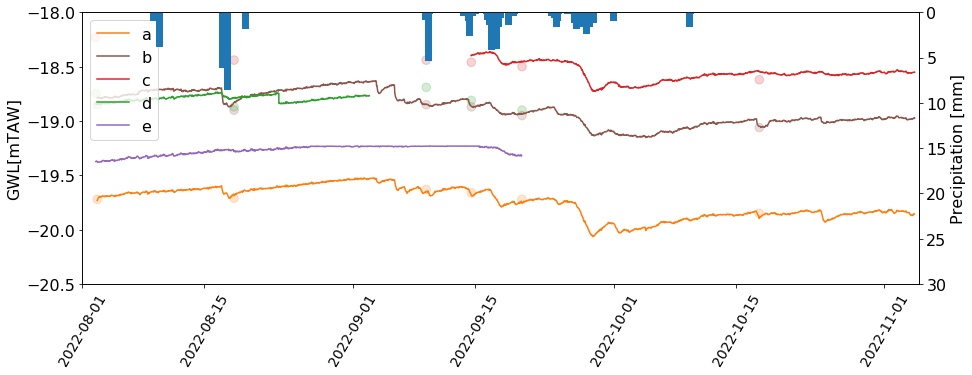

In [27]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969'], 
            'WellName' : {'a','b','c','d','e'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.30,20.5,19.7,20.9,22.3],
            'well_height' : [0.56,0.43,0.63,0.68,0.70],
            'top_well_cm' :[2186,2093,2033,2158,2300],
            'RL' : [350,332,341,370,377],
            'L1':[294,289,278,302,307],
            'initials' : [158,165,147,225,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2021-08-02 13:00:00'],
           'long':[108855,108899,108929,108884,108814],
           'lat':[185311,185293,185281,185274,185203]}
alldata={}
dov={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2022,11,5)
ftsz=16

fig, ax= plt.subplots(figsize=(15,5))
axb=ax.twinx()



for f,i in enumerate(wellinfo['SerialNumber']):
    ddd=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall=baro_data.merge(ddd[['TimeStamp','Pressure']], on='TimeStamp')
    dataall.SerialNumber=i
    dataall[dataall['Pressure_y'].notna()]
    dataall = dataall[dataall['Pressure_x']<dataall['Pressure_y']]
    dataall["WL"]=(dataall['Pressure_y']-dataall['Pressure_x'])
    dataall=dataall.reset_index()
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataall["GWL"]=PiezoD['RL']-PiezoD['TopWell']-dataall["WL"]
    else:
        dataall["GWL"]=wellinfo['RL'][f]-wellinfo['top_well_cm'][f]-dataall["WL"]
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall.TimeStamp[840:],(dataall["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall.TimeStamp,(dataall["GWL"]/100),colors[i])
    ax.set_ylim([-20.5,-18])
    alldata[i]=dataall
    
    #calulcate based on TAW
    #
    #
    #
    #create data for DOV ???
    dov[i]=([[dataall["TimeStamp"].dt.strftime('%Y-%m-%dT%H:%M:%S.000+01:00')],-dataall["GWL"]/100])
    #
    #
    #dov[i].to_csv(wellinfo['lgnds'][f]+'_DOV.csv', index=False,header=False) 

ax.scatter(df_info2.Time, df_info2.iloc[:,5], 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[mTAW]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)



axb.bar(clim['date_time'],clim.precipitation)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

print(dataall)
